In [1]:
import matplotlib.pyplot as plt
from well_stirred_r import WellStirredReactor as WSR
import numpy as np
import cantera as ct

In [17]:
# create instance of object
reactor = WSR()
species = reactor.species_names
species

['T', 'H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'AR', 'N2']

In [18]:
t_list = [] # This list stores the value of different residence times
y_list = [] # This list stores the states at the diferent resident times selected
residence_time = 0.1  # starting residence time

while reactor.gas.T > 800:
    reactor = WSR(volume = 1,
    res_time = residence_time,
    inlet_temp = 300,
    reactor_temp=2100,
    heat_loss = 0,
    pressure = ct.one_atm,
    inlet_gas='H2:2,O2:1,N2:4')
    
    t,y = reactor.solve_ode(dt = 1e-6)
    t_list.append(t[-1])
    y_list.append(y[-1,:])
    
    residence_time *= 0.9  # decrease the residence time for the next iteration

### Using Cantera to Model WSR For result Comparison

In [19]:
# Use reaction mechanism GRI-Mech 3.0. For 0-D simulations,
# no transport model is necessary.
gas = ct.Solution('h2o2.yaml')

# Create a Reservoir for the inlet, set to a methane/air mixture as our custom case

gas.TPX = 300, ct.one_atm, 'H2:2,O2:1,N2:4'
#gas.set_equivalence_ratio(equiv_ratio) #gas.X= 'H2:2,O2:1,N2:4' #
inlet = ct.Reservoir(gas)


gas.equilibrate('HP')
combustor = ct.IdealGasReactor(gas)
combustor.volume = 1.0

# Create a reservoir for the exhaust
exhaust = ct.Reservoir(gas)

# Use a variable mass flow rate to keep the residence time in the reactor
# constant (residence_time = mass / mass_flow_rate). The mass flow rate function
# can access variables defined in the calling scope, including state variables
# of the Reactor object (combustor) itself.


def mdot(t):
    return combustor.mass / residence_time


inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=mdot)

# A PressureController has a baseline mass flow rate matching the 'master'
# MassFlowController, with an additional pressure-dependent term. By explicitly
# including the upstream mass flow rate, the pressure is kept constant without
# needing to use a large value for 'K', which can introduce undesired stiffness.
outlet_mfc = ct.PressureController(combustor, exhaust, master=inlet_mfc, K=0.01)

# the simulation only contains one reactor
sim = ct.ReactorNet([combustor])

# Run a loop over decreasing residence times, until the reactor is extinguished,
# saving the state after each iteration.
states = ct.SolutionArray(gas, extra=['tres'])

residence_time = 0.1  # starting residence time
while combustor.T > 300:
    sim.set_initial_time(0.0)  # reset the integrator
    sim.advance_to_steady_state()
    # print('tres = {:.2e}; T = {:.1f}'.format(residence_time, combustor.T))
    states.append(combustor.thermo.state, tres=residence_time)
    residence_time *= 0.9  # decrease the residence time for the next iteration

### Plotting of Results

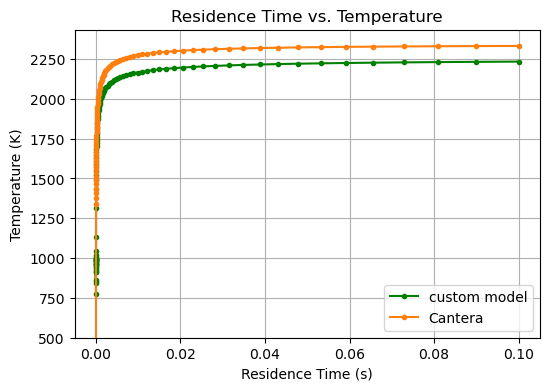

In [23]:
import matplotlib.pyplot as plt

# Plotting code
plt.figure(figsize=(6, 4))
plt.plot(t_list, np.array(y_list)[:, 0], '.-', label='custom model', color = 'green')
plt.plot(states.tres[:-1], states.T[:-1], '.-', color='C1', label='Cantera')

# Set y-axis limits
plt.ylim(500, None)

# Add labels, title, etc.
plt.xlabel('Residence Time (s)')
plt.ylabel('Temperature (K)')
plt.title('Residence Time vs. Temperature')
plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.show()


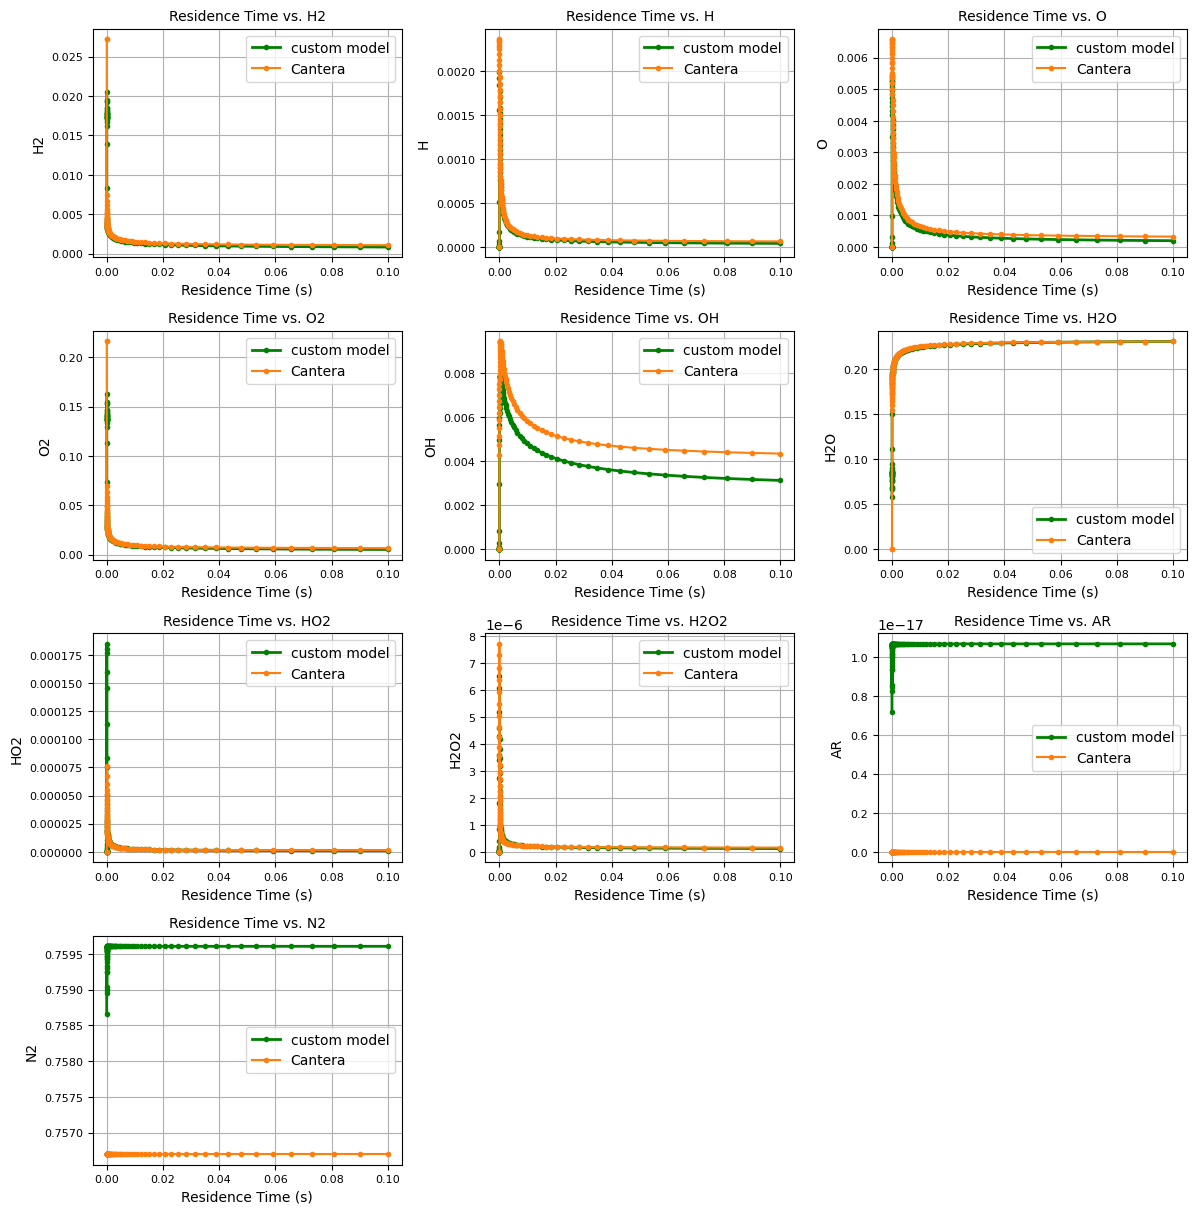

In [35]:
import matplotlib.pyplot as plt

n = len(species)-1
# Create subplots
fig, axes = plt.subplots(nrows=np.int(n+1/3), ncols=3, figsize=(12, 30))
plt.subplots_adjust(hspace=1)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through each subplot
for i in range(0, n):
    # Plotting code
    ax = axes[i]
    ax.plot(t_list, np.array(y_list)[:, i+1], '.-', label='custom model', linewidth=2.0, color='green')
    ax.plot(states.tres, states.Y[:, i], '.-', color='C1', label='Cantera')

    # Set y-axis limits
    # ax.set_ylim(1100, None)

    # Add labels, title, etc.
    ax.set_xlabel('Residence Time (s)')
    ax.set_ylabel(f'{species[i + 1]}')
    ax.set_title(f'Residence Time vs. {species[i + 1]}',fontsize = 10)
    ax.grid(True)
    
    axes[i].tick_params(axis='both', which='both', labelsize=8)  # Set tick label size
    axes[i].ticklabel_format(useOffset=True)

    # Add legend
    ax.legend()

# Remove unused subplots
for ax in axes[len(species) - 1:]:
    ax.set_visible(False)


# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
